In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.utils import shuffle

! pip install openpyxl

In [26]:
all_df = pd.read_excel('Real_estate_valuation_data_set.xlsx',index_col=False)
all_df = shuffle(all_df)
all_df

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
299,300,2013.166667,33.2,121.7262,10,24.98178,121.54059,46.1
369,370,2012.666667,20.2,2185.1280,3,24.96322,121.51237,22.8
170,171,2013.333333,24.0,4527.6870,0,24.94741,121.49628,14.4
93,94,2012.916667,31.9,1146.3290,0,24.94920,121.53076,16.1
245,246,2013.416667,7.5,639.6198,5,24.97258,121.54814,40.8
...,...,...,...,...,...,...,...,...
370,371,2012.750000,15.9,289.3248,5,24.98203,121.54348,42.1
232,233,2012.916667,27.1,4412.7650,1,24.95032,121.49587,17.4
306,307,2013.500000,14.4,169.9803,1,24.97369,121.52979,50.2
358,359,2013.166667,1.1,193.5845,6,24.96571,121.54089,45.1


In [27]:
all_df.info()
all_df = all_df.drop("No",axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 299 to 79
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 29.1 KB


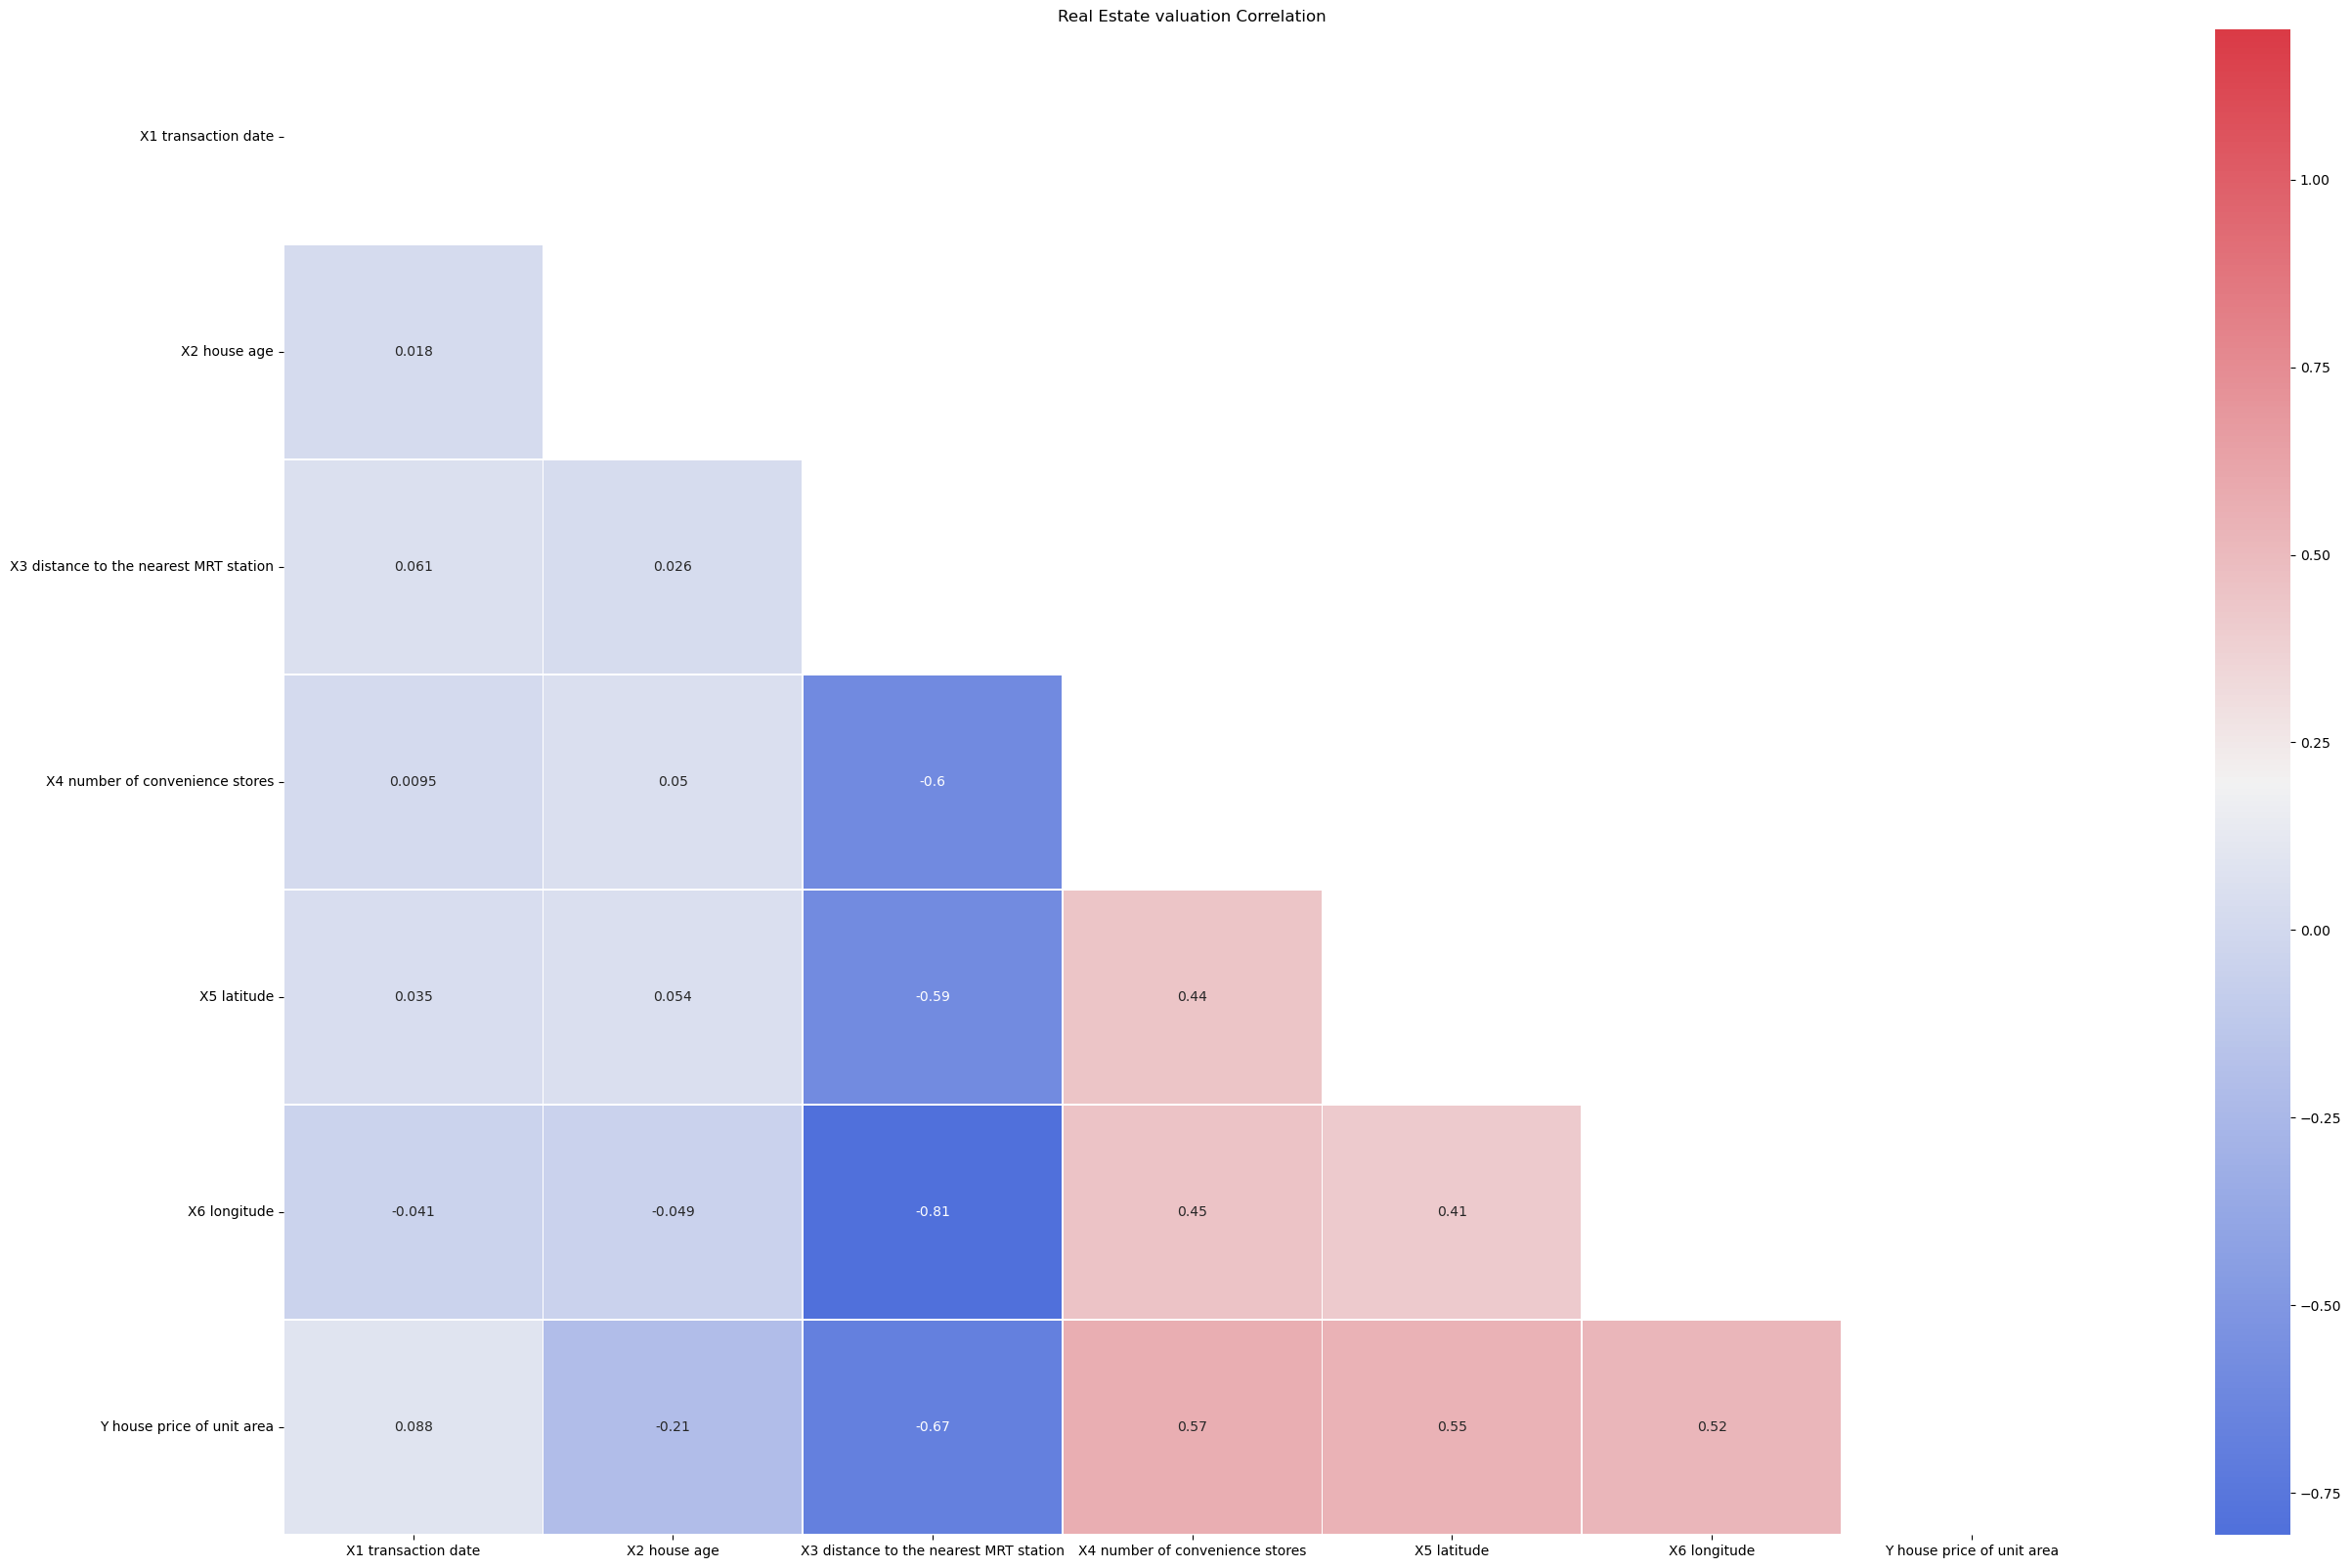

In [28]:
corrMatt = all_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 20))
plt.title('Real Estate valuation Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=True, fmt='.2g', linewidths=0.5);

In [29]:
Xs = all_df.drop("Y house price of unit area",axis=1)
target = all_df['Y house price of unit area']

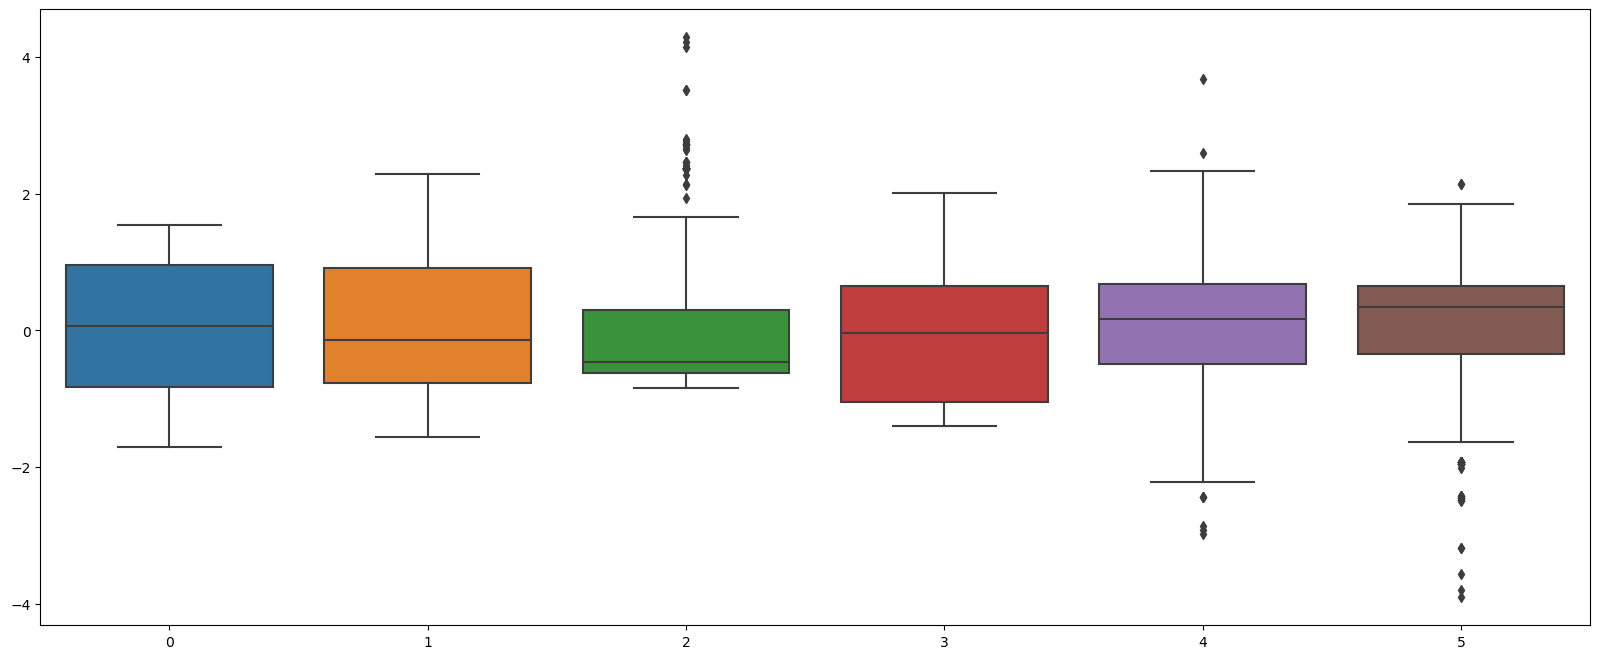

In [30]:
scaler = StandardScaler()
features = scaler.fit_transform(Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=features,ax=ax)

In [60]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [31]:
#define currency conversion
def curr_conversion(score):
    result = np.sqrt(score)
    result = result/3.3
    result = result/37
    return result

### 2. Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
cv_error = np.average(cross_val_score(clf, features, target, scoring = 'neg_mean_absolute_error')) * (-1)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, cv_error))

The 5-fold cross-validation accuracy score for this classifier is 6.25


In [33]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(cv_error)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.02047


### 3. SVM

In [34]:
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

svm = SVR(kernel="rbf", gamma='auto')

In [35]:
cv_error_array = cross_val_score(svm, features, target,scoring='neg_mean_absolute_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation accuracy score for this classifier is 5.94


In [36]:
from sklearn.metrics import mean_squared_error
y_true = [30, 40]
y_pred = [50, 60]
mean_squared_error(y_true, y_pred, squared=True)

400.0

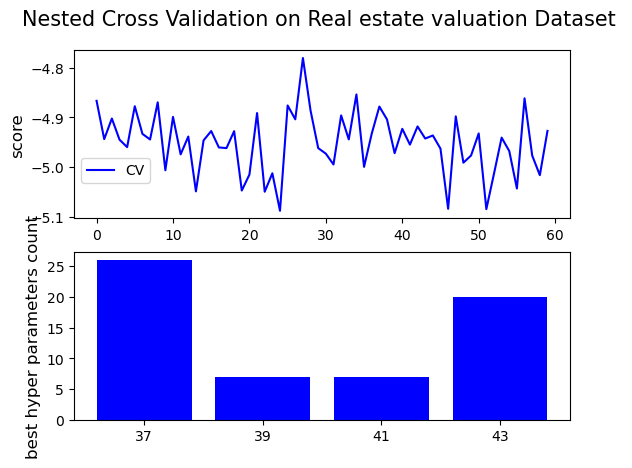

In [37]:
NUM_TRIALS = 60
X = features
y = target

# Set up possible values of parameters to optimize over
p_grid = {"C": [37,39,41,43]}

scores = np.zeros(NUM_TRIALS)
params = []

for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring='neg_mean_absolute_error')
    clf.fit(X,y)
    scores[i] = clf.best_score_
    params.append(clf.best_params_)


best_hyper_params_count = np.zeros(4)
for i in params:
    if params.count(i) >= 1:
        best_hyper_params_count[int((i["C"]-37)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation on Real estate valuation Dataset ",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.subplot(212)

plt.bar(range(len(best_hyper_params_count)), best_hyper_params_count,fc='b', tick_label=[37,39,41,43])
plt.ylabel("best hyper parameters count", fontsize="12")
plt.show()

In [38]:
svm = SVR(C = 37,kernel="rbf", gamma='auto')
cv_error_array = cross_val_score(svm, features, target,scoring='neg_mean_absolute_error') * (-1)
average = np.average(cv_error_array)
print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation accuracy score for this classifier is 5.04


In [39]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.01839


### 4. Decision Tree

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [41]:
tree_dtr = tree.DecisionTreeRegressor()

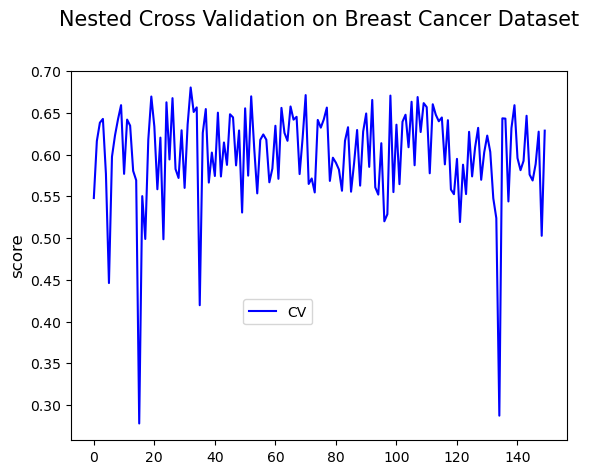

In [42]:
from sklearn.model_selection import KFold

NUM_TRIALS = 150

X = features
y = target

p_grid = {'max_depth': [3, 5, 7, 9, 11], 'min_samples_split':[5, 10, 15]}
scores = np.zeros(NUM_TRIALS)
params = []
for i in range(NUM_TRIALS):

    cv = KFold(n_splits=5, shuffle=True, random_state=i)

    dtr = GridSearchCV(estimator=tree_dtr, param_grid=p_grid, cv=cv)
    dtr.fit(X,y)
    scores[i] = dtr.best_score_
    params.append(dtr.best_params_)
    best_hyper_params_count = [[0 for i in range(5)] for j in range(3)]
    
for i in params:
    best_hyper_params_count[int(i['min_samples_split']/5-1)][int((i['max_depth']-3)/2)] = params.count(i)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
(line,) = plt.plot(scores, color="b")
plt.ylabel("score", fontsize="12")
plt.legend(
    [line],
    ["CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Nested Cross Validation on Breast Cancer Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

plt.show()

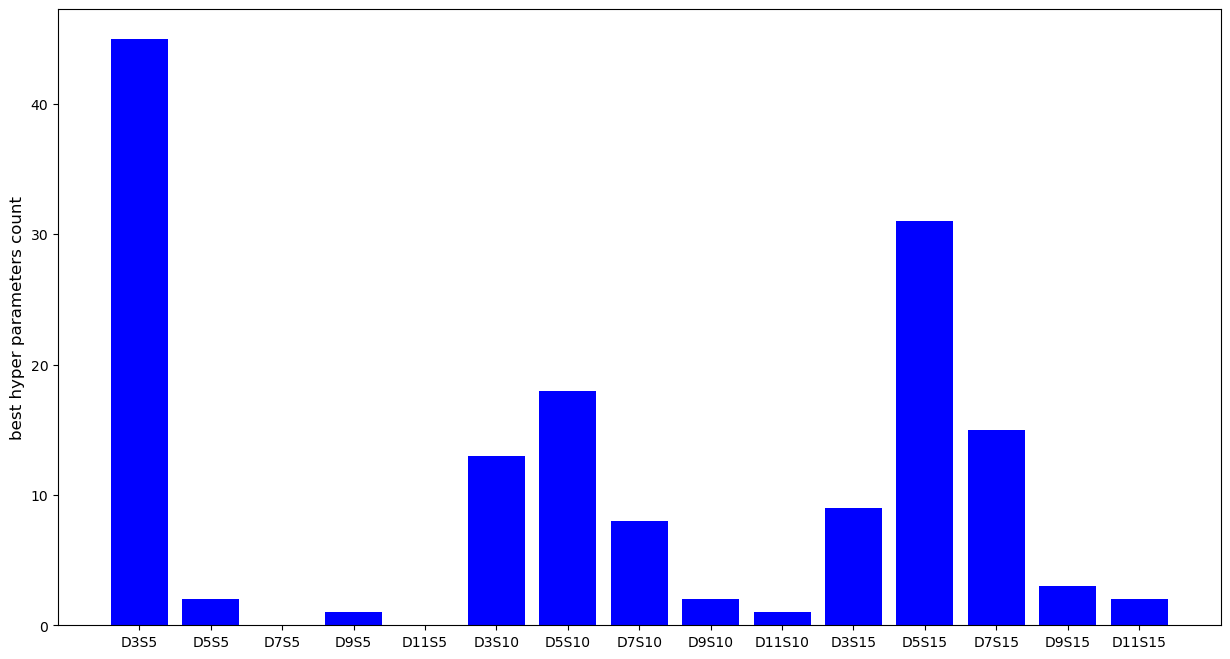

In [43]:
plt.figure(figsize = (15,8))

whole_list = best_hyper_params_count[0] + best_hyper_params_count[1] + best_hyper_params_count[2]

lang = []

for j in range(5,20,5):
    for i in range(3,13,2):
        lang.append('D' + str(i) + 'S' + str(j))       

plt.bar(range(len(whole_list)), whole_list, fc='b', tick_label=lang)

plt.ylabel("best hyper parameters count", fontsize="12")

plt.show()

In [44]:
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 5)

cv_error_array = cross_val_score(tree_reg, features, target, scoring='neg_mean_absolute_error') * (-1)

average = np.average(cv_error_array)

print('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(5, average))

The 5-fold cross-validation accuracy score for this classifier is 5.65


In [45]:
print('10000 NTD per Ping converted into 10000 GBD per meter squared :{:.5f}'.format(curr_conversion(average)))

10000 NTD per Ping converted into 10000 GBD per meter squared :0.01946


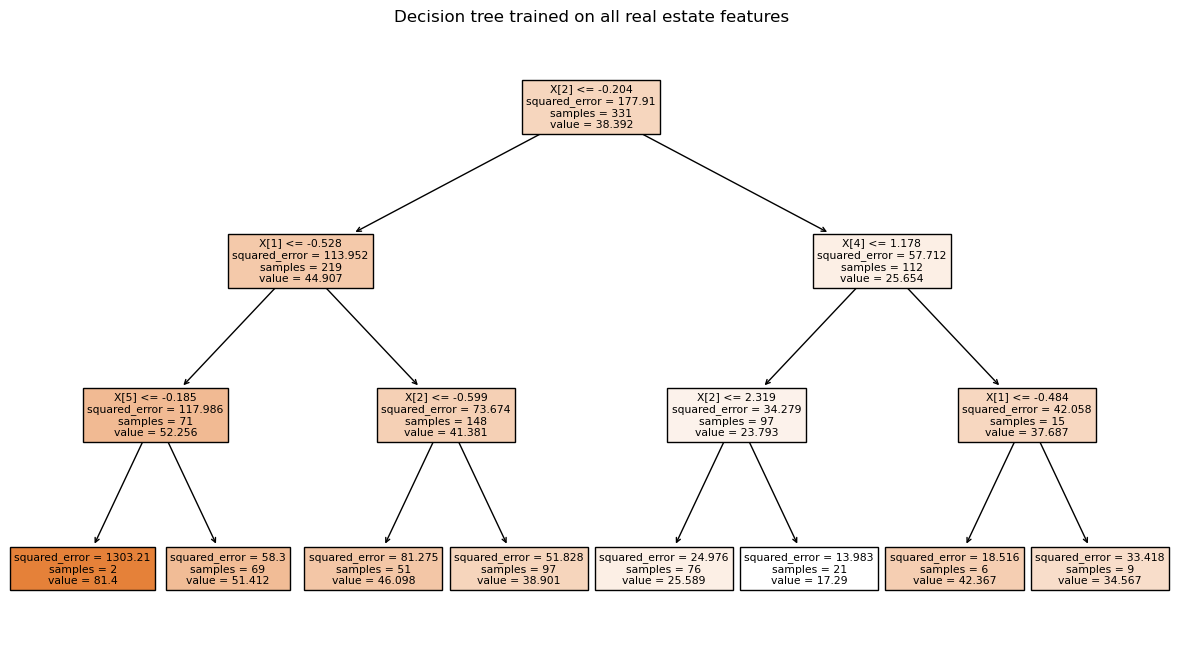

In [61]:
from sklearn.tree import plot_tree

plt.figure(figsize = (15,8))
plot_tree(tree_reg.fit(x_train, y_train), filled=True)
plt.title("Decision tree trained on all real estate features")
plt.show()